In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Persuasion for Good dataset along with metrics information

In [69]:
PFG_METRICS_FILE = 'data/pfg_metrics.csv'

pfg_metrics = pd.read_csv(PFG_METRICS_FILE)

In [70]:
feature_cols = [x for x in pfg_metrics.columns if x not in ("B2", "Combined_Text")]

### EDA

##### Feature columns visualization

In [71]:
def visualize_percentage_distribution(df, cols):
    """
    Visualize the percentage distribution of specified columns in a DataFrame.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    cols (list): List of column names to visualize.
    """
    for col in cols:
        # Calculate percentage distribution
        percentage_dist = df[col].value_counts(normalize=True) * 100
        
        # Create the bar plot
        plt.figure(figsize=(12, 6))
        percentage_dist.plot(kind='bar')
        
        # Customize the plot
        plt.title(f'Percentage Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Percentage (%)')
        plt.ylim(0, 100)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right')
        
        # Add percentage labels on top of each bar
        for i, v in enumerate(percentage_dist):
            plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
        
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()

#### Visualize the percentage distribution of the feature columns
# visualize_percentage_distribution(pfg_metrics, feature_cols)

### Persuasion Information of PFG

In [72]:
info_data = pd.read_excel('data/persuasion_for_good/300_info.xlsx', sheet_name='Sheet1')

#### EDA of info data

In [73]:
info_data.isna().sum()  # Check for missing values
# B5 is missing -> Valid reason is that persuadee did not provide the information so set it as 0

# Remove persuader data for now to get the persuasion data
info_data = info_data[info_data['B4'] != 0]
info_data['B5'] = info_data['B5'].fillna(0)
info_data['B6'] = info_data['B6'].fillna(0)

--------
Missing prior information is missing. -> So persuasion will be modelled as 'B5'

Text embedding -> 
--------

##### Persuasion as diff between B5 and B6

In [74]:
info_data['persuasion'] = info_data['B6'] - info_data['B5']

# Visualize the distribution of persuasion values if we make it as classification problem
increase_df = info_data[info_data['persuasion'] > 0]
decrease_df = info_data[info_data['persuasion'] < 0]
same_df = info_data[info_data['persuasion'] == 0]

print(f"Average increase: {increase_df['persuasion'].mean()}")
print(f"Average decrease: {decrease_df['persuasion'].mean()}")
print(f"Average same: {same_df['persuasion'].mean()}")

Average increase: 1.8223255813953492
Average decrease: -107.30152777777779
Average same: 0.0


<AxesSubplot: >

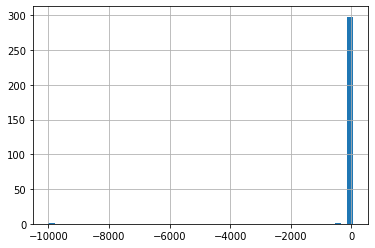

In [75]:
info_data['persuasion'].hist(bins=50) # Clearly an outlier

#### Invalid datapoints



##### Outliers

In [76]:
# Outliers
# Based on scipy.stats.zscore, we can remove the outliers
from scipy.stats import zscore

info_data['zscore'] = zscore(info_data['persuasion'])
info_data = info_data[info_data['zscore'].abs() < 3]

In [77]:
# Drop the records if the initial value is > 2
print(f"Dropping the records whose initial values > 2 as 2 is the capped value: {info_data[info_data['B5'] > 2].shape[0]}")
print(f"Dropping the records whose final values > 2 as 2 is the capped value: {info_data[info_data['B6'] > 2].shape[0]}")
# info_data = info_data[info_data['B5'] <= 2]


Dropping the records whose initial values > 2 as 2 is the capped value: 51
Dropping the records whose final values > 2 as 2 is the capped value: 10


In [78]:
info_data_prime = info_data[(info_data['B5'] <= 2) & (info_data['B6']<= 2)]

In [79]:
# pfg_metrics.head(2)
# info_data['B6'].hist(bins=50)

In [80]:
data_df = pd.merge(pfg_metrics, info_data_prime, on='B2', how='inner')
data_df

,B2,Combined_Text,Framing,Priming,Repetition,Narrative/Story,Reciprocity,Commitment and Consistency,Social Proof,Scarcity,...,Credibility Markers,Certainty Markers,Rhetorical Questions,B3,B4,B5,B6,B7,persuasion,zscore
0,20180717-200206_41_live,"Persuader: Hey, how are you doing, have you ev...",Yes,No,Yes,Yes,No,Yes,No,No,...,No,No,Yes,user_1494,1,0.5,0.50,10.0,0.00,0.066496
1,20180719-120436_413_live,Persuader: Hi there\r\nPersuadee: Hello\r\nPer...,Yes,Yes,Yes,Yes,No,Yes,Yes,No,...,No,Yes,Yes,user_1363,1,0.0,0.00,10.0,0.00,0.066496
2,20180719-175233_833_live,Persuader: Hey there\r\nPersuadee: Hey how's i...,Yes,Yes,No,Yes,Yes,Yes,No,No,...,No,Yes,Yes,user_324,1,0.0,0.05,10.0,0.05,0.066583
3,20180719-202443_897_live,"Persuader: Hey, how's it going tonight?\r\nPer...",Yes,No,No,No,No,Yes,Yes,No,...,Yes,No,Yes,user_1762,1,1.0,1.00,10.0,0.00,0.066496
4,20180719-204358_391_live,"Persuader: Hey there, glad we can talk tonight...",Yes,No,No,No,Yes,Yes,No,No,...,No,No,Yes,user_685,1,0.5,0.00,10.0,-0.50,0.065630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,20180904-030739_178_live,Persuader: Do you ever donate to charity?\r\nP...,Yes,Yes,No,No,Yes,No,Yes,No,...,Yes,Yes,Yes,user_621,1,0.0,0.00,10.0,0.00,0.066496
242,20180904-032932_423_live,Persuader: Hello.\r\nPersuader: Would you like...,Yes,No,Yes,No,No,Yes,Yes,No,...,Yes,Yes,Yes,user_1169,1,1.0,1.00,11.0,0.00,0.066496
243,20180904-043300_214_live,Persuader: Hi!\r\nPersuader: How are you doing...,No,No,No,No,No,No,No,No,...,Yes,No,No,user_1473,1,0.0,0.00,10.0,0.00,0.066496
244,20180904-045349_715_live,Persuader: Good morning.\r\nPersuader: How are...,Yes,No,Yes,No,Yes,No,Yes,No,...,Yes,No,No,user_1810,1,0.2,0.00,11.0,-0.20,0.066149


In [81]:
# Label encode the categorical columns except the columns ['B2', 'Combined_Text', 'persuasion', 'B3', 'B4', 'B5', 'B6', 'B7']
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
categorical_cols = [col for col in data_df.columns if col not in ['B2', 'Combined_Text', 'persuasion', 'B3', 'B4', 'B5', 'B6', 'B7', 'zscore']]
data_df[categorical_cols] = data_df[categorical_cols].apply(label_encoder.fit_transform)


In [82]:
categorical_cols

['Framing',
 'Priming',
 'Repetition',
 'Narrative/Story',
 'Reciprocity',
 'Commitment and Consistency',
 'Social Proof',
 'Scarcity',
 'Authority',
 'Liking',
 'Argument Type',
 'Hedging and Politeness',
 'Pronoun Use',
 'Active Tense',
 'Concreteness',
 'Linguistic Fluency',
 'Linguistic Mirroring',
 'Credibility Markers',
 'Certainty Markers',
 'Rhetorical Questions']

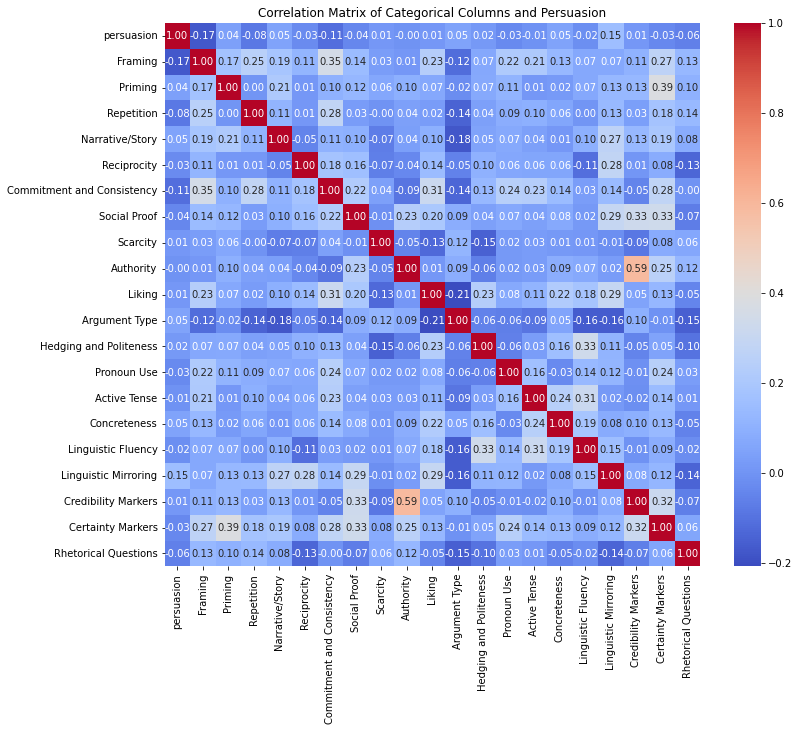

In [83]:
# Pairplot of categorical columns and the persuasion column
# sns.pairplot(data_df[['persuasion'] + categorical_cols])


# Correlation matrix of the categorical columns and the persuasion column
corr = data_df[['persuasion'] + categorical_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Categorical Columns and Persuasion')
plt.show()

Mean Squared Error: 0.13
R^2 Score: 0.03


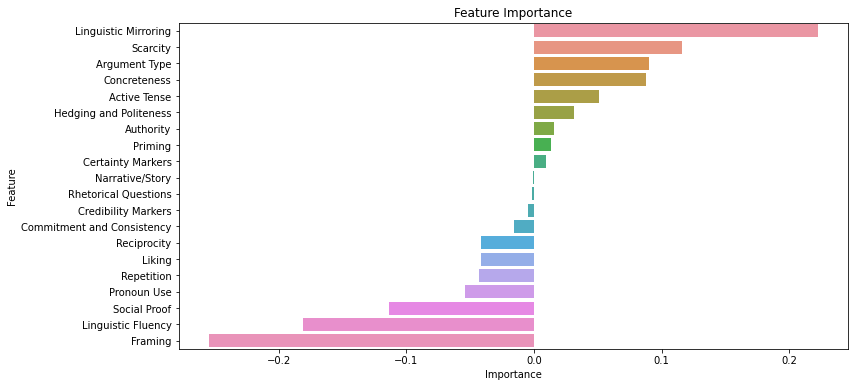

In [84]:
# Fit a linear regression model to predict the persuasion column using the categorical columns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = data_df[categorical_cols]
y = data_df['persuasion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Feature importance
importance = model.coef_
feature_importance = pd.DataFrame(importance, index=categorical_cols, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y=feature_importance.index, data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Mean Squared Error: 0.19
R^2 Score: -0.48


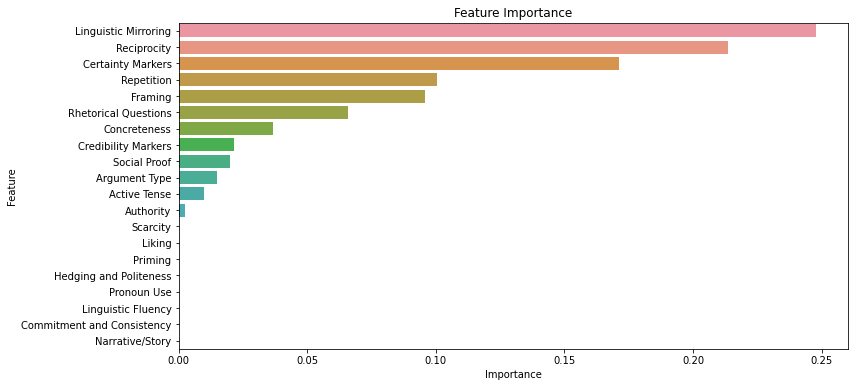

In [85]:
# Fit a decision tree model to predict the persuasion column using the categorical columns

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# Reduce the overfitting by setting the max_depth to 5
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame(importance, index=categorical_cols, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y=feature_importance.index, data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

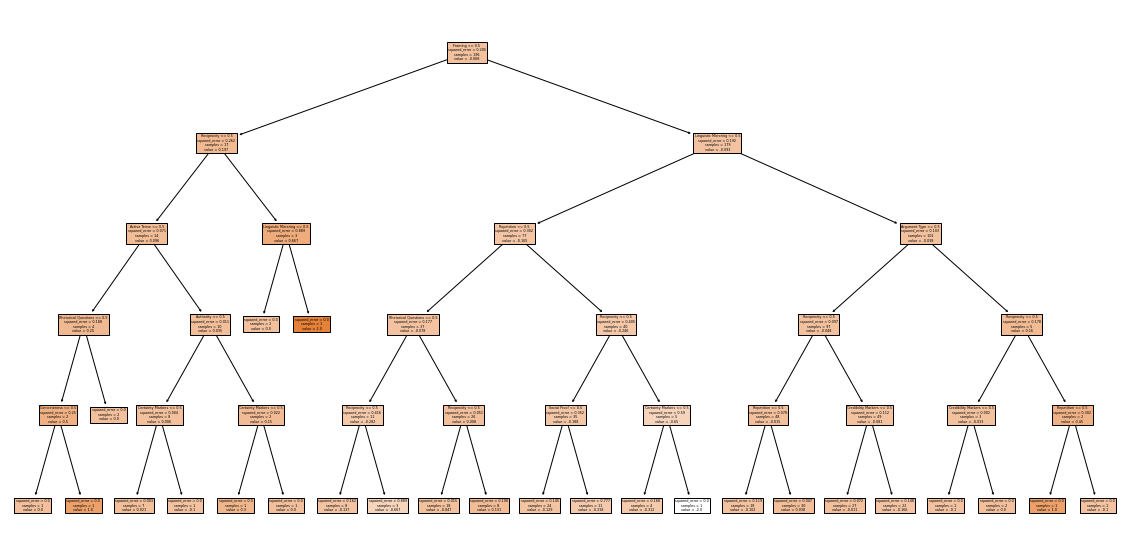

In [86]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=categorical_cols, filled=True)
plt.show()

Mean Squared Error: 0.17
R^2 Score: -0.30


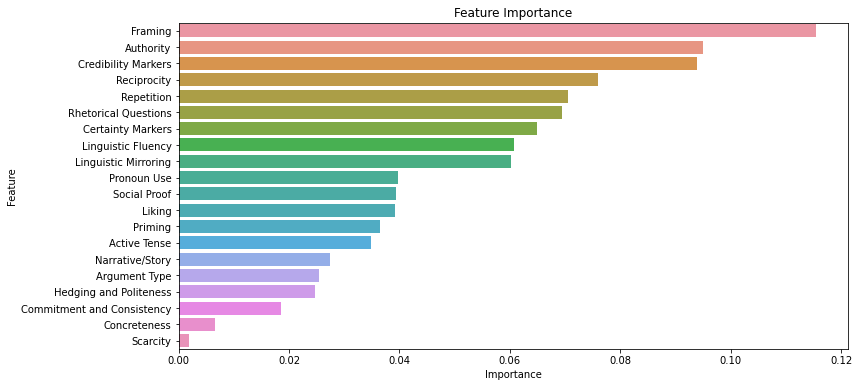

In [87]:
# XGBoost model
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Feature importance
importance = model.feature_importances_
feature_importance = pd.DataFrame(importance, index=categorical_cols, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y=feature_importance.index, data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [88]:
!pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


<AxesSubplot: >

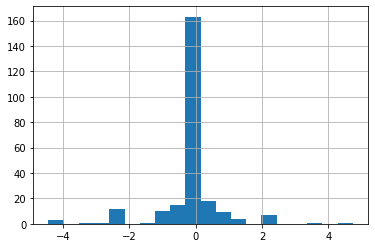

In [89]:


# Remove the outliers from the persuasion column
from scipy.stats import zscore

data_df['z_score'] = zscore(data_df['persuasion'])

# Distruibution of the z-score
data_df['z_score'].hist(bins=20)


# # Remove the rows with z-score greater than 3 or less than -3
# data_df = data_df[(data_df['z_score'] < 3) & (data_df['z_score'] > -3)]

# # Fit a linear regression model to predict the persuasion column using the categorical columns
# X = data_df[categorical_cols]
# y = data_df['persuasion']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = LinearRegression()
# model.fit(X_train, y_train)

# # Evaluate the model
# y_pred = model.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f'Mean Squared Error: {mse:.2f}')
# print(f'R^2 Score: {r2:.2f}')

In [90]:
data_df[abs(data_df['z_score']) > 3]

,B2,Combined_Text,Framing,Priming,Repetition,Narrative/Story,Reciprocity,Commitment and Consistency,Social Proof,Scarcity,...,Certainty Markers,Rhetorical Questions,B3,B4,B5,B6,B7,persuasion,zscore,z_score
5,20180719-210146_172_live,Persuader: Hello.\r\nPersuader: How are you?\r...,1,0,1,0,1,1,0,0,...,1,1,user_446,1,2.0,0.0,10.0,-2.0,0.063030,-4.440333
7,20180719-211846_176_live,"Persuader: hi, how are you?\r\nPersuadee: I'm ...",1,0,1,0,0,1,1,0,...,0,1,user_473,1,1.5,0.0,10.0,-1.5,0.063896,-3.293623
39,20180723-113128_856_live,"Persuader: Hi, how much do you know about Save...",0,0,1,0,1,1,0,0,...,1,0,user_1332,1,0.0,2.0,11.0,2.0,0.069962,4.733351
64,20180808-035715_390_live,"Persuader: Hello, how are you doing today?\r\n...",1,0,0,0,1,1,1,0,...,1,0,user_243,1,2.0,0.0,10.0,-2.0,0.063030,-4.440333
186,20180826-180300_663_live,Persuader: Good afternoon/evening\r\nPersuadee...,1,0,1,0,0,1,1,0,...,1,1,user_667,1,2.0,0.0,11.0,-2.0,0.063030,-4.440333
209,20180827-033451_673_live,"Persuader: Hi there, how are you this morning?...",1,0,1,0,0,1,1,0,...,1,1,user_804,1,0.5,2.0,11.0,1.5,0.069096,3.586640
